In [1]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [2]:
# Habilitar cuda se ela estiver disponível
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

## Carregamento dos dados

In [3]:
df_lithology = pd.read_csv('lithology.csv', sep=';')

In [4]:
df_lithology.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,24.735691,0.314847,0.150172,-0.000000,-0.000000,-0.000000,0.000,0.000000,6,68
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,24.492376,0.318528,0.148269,0.527710,-0.005608,0.937965,0.152,-0.243315,6,68
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,24.202299,0.322946,0.139258,0.429855,-0.006729,4.440887,0.152,-0.290077,6,68
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,24.400797,0.319919,0.135315,0.024185,0.004610,1.943077,0.152,0.198498,6,68
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,24.916765,0.312121,0.132982,0.021088,0.011879,1.149780,0.152,0.515968,6,68


## Rápido EDA

In [5]:
df_lithology['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()

65000.0    720803
30000.0    168937
65030.0    150455
70000.0     56320
80000.0     33329
99000.0     15245
70032.0     10513
88000.0      8213
90000.0      3820
74000.0      1688
86000.0      1085
93000.0       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

<AxesSubplot:>

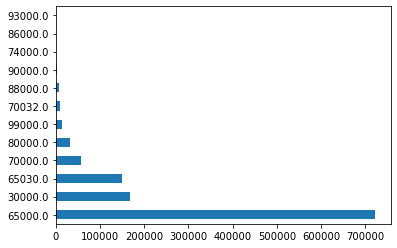

In [6]:
df_lithology['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts().plot(kind = 'barh')

A base contém um desbalanceamento. Será lidado com ele usando estratégias de split estratificado.

In [7]:
df_lithology.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'Carbon_Index',
       'Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB',
       'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index', 'GROUP_encoded',
       'FORMATION_encoded'],
      dtype='object')

As colunas que contém no nome _Normalized_ ou _Delta_ já devem ter passado por algum processamento. A coluna _FORCE_2020_LITHOFACIES_LITHOLOGY_ é o que se quer prever.

In [8]:
df_lithology.corr()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
DEPTH_MD,1.000000,-0.081904,0.249745,-0.987890,0.242287,0.072961,0.055864,0.062862,0.267399,0.098282,...,0.252801,0.267160,0.044830,0.215984,0.266868,0.000432,0.002445,0.266868,0.056807,-0.293998
X_LOC,-0.081904,1.000000,0.416875,0.085877,-0.249819,-0.164608,-0.044303,0.054780,0.098533,0.231190,...,0.096850,0.098485,0.167773,-0.071248,0.098435,-0.000287,0.000974,0.098434,0.094923,-0.225151
Y_LOC,0.249745,0.416875,1.000000,-0.259623,-0.148181,-0.175650,0.109941,0.009231,0.106056,0.206453,...,0.102346,0.105965,0.131760,0.047832,0.105851,-0.000184,0.002194,0.105851,0.024585,-0.163860
Z_LOC,-0.987890,0.085877,-0.259623,1.000000,-0.234391,-0.088610,-0.087831,-0.111010,-0.277483,-0.101529,...,-0.262971,-0.277247,-0.043703,-0.208389,-0.276951,-0.000414,-0.002509,-0.276951,-0.044176,0.291771
CALI,0.242287,-0.249819,-0.148181,-0.234391,1.000000,0.230859,0.200187,0.059856,0.290623,-0.131479,...,0.288104,0.290592,-0.133204,0.394364,0.290467,0.000167,0.000338,0.290466,0.055227,0.017484
RSHA,0.072961,-0.164608,-0.175650,-0.088610,0.230859,1.000000,0.038447,0.041122,0.113860,-0.043932,...,0.112537,0.113915,-0.063521,0.088760,0.113818,-0.000398,-0.001663,0.113820,-0.011004,0.001706
RMED,0.055864,-0.044303,0.109941,-0.087831,0.200187,0.038447,1.000000,0.093780,0.204210,0.117150,...,0.204782,0.204219,0.087406,0.350722,0.204328,0.001224,0.000175,0.204323,-0.031007,-0.022347
RDEP,0.062862,0.054780,0.009231,-0.111010,0.059856,0.041122,0.093780,1.000000,0.113988,0.009550,...,0.114447,0.113994,0.003944,0.090665,0.114003,0.000662,0.000325,0.114004,0.045048,-0.006239
RHOB,0.267399,0.098533,0.106056,-0.277483,0.290623,0.113860,0.204210,0.113988,1.000000,-0.002582,...,0.999727,1.000000,-0.062674,0.462418,0.999583,0.000408,0.000908,0.999579,0.022361,-0.127749
GR,0.098282,0.231190,0.206453,-0.101529,-0.131479,-0.043932,0.117150,0.009550,-0.002582,1.000000,...,-0.006083,-0.002662,0.583831,-0.074397,-0.002677,-0.051292,-0.000304,-0.002682,0.062451,-0.172180


## Mapeamento e preparação do dataset

Criação de listas e mapas para mapear os dados da coluna _FORCE_2020_LITHOFACIES_LITHOLOGY_ conforme o padrão do PyTorch

In [9]:
# Colocando as classes em uma lista
classes = [30000, 65030, 65000, 80000, 74000, 70000, 70032, 88000, 86000, 99000, 90000, 93000]

# Fazendo o mapeamento das classes para indexs e vice-versa
class_to_idx_map = {clazz: index for index, clazz in enumerate(classes)}

idx_to_class_map = {value: key for key, value in class_to_idx_map.items()}

In [10]:
# Aplicando o mapeamento
df_lithology['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df_lithology['FORCE_2020_LITHOFACIES_LITHOLOGY'].apply(lambda x: class_to_idx_map[x])

Separação dos valores que serão classificados (Y) dos valores que serão usados para fazer a classificação (X)

In [11]:
y = df_lithology['FORCE_2020_LITHOFACIES_LITHOLOGY']
df_lithology_features = df_lithology.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY'])

In [12]:
df_lithology_features.columns

Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'Carbon_Index', 'Normalized_RHOB', 'Normalized_GR',
       'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD',
       'Delta_Carbon_Index', 'GROUP_encoded', 'FORMATION_encoded'],
      dtype='object')

In [13]:
def get_features(df, features, add_encoded = False):
    """
    Separa e retorna as características desejadas do dataset de lithology

    Arguments:
    df -- o dataframe pandas de lithology.
    features -- String representando o tipo de características desejadas:
        - 'normalized': só as colunas com 'Normalized' ou 'Delta' no nome sem as colunas com 'encoded' no nome;
        - 'normal': só as colunas sem 'Normalized' ou 'Delta' ou 'encoded' no nome;
        - 'all': retorna o dataset inteiro
    add_encoded -- Boolean, default False. Se True adiciona as colunas com 'encoded' no nome ao retorno. 
        Não surte efeito se o valor 'all' for informado para o parâmetro 'features'

    Return:
    df_features -- dataframe com as caracteristicas desejadas
    """
    if features == 'normalized':
        df_features = df.loc[:, ['Normalized_RHOB', 'Normalized_GR', 'Delta_DTC', 'Delta_RHOB', 'Delta_GR', 'Delta_DEPTH_MD', 'Delta_Carbon_Index']]
    elif features == 'normal':
        df_features = df.loc[:, ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'Carbon_Index']]
    elif features == 'all':
        df_features = df
        
    # Adicionar dados encoded
    if add_encoded == True and features != 'all':
        df_features['GROUP_encoded'] = df['GROUP_encoded']
        df_features['FORMATION_encoded'] = df['FORMATION_encoded']
        
    return df_features

In [14]:
df_features = get_features(df_lithology_features, 'normal')
df_features.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,PEF,DTC,SP,BS,ROP,DCAL,DRHO,MUDWEIGHT,RMIC,Carbon_Index
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,-999.0,1.611410,1.798681,1.884186,80.200851,...,20.915468,161.131180,24.612379,17.5,34.636410,1.980835,-0.574928,-999.0,-999.0,24.735691
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,-999.0,1.618070,1.795641,1.889794,79.262886,...,19.383013,160.603470,23.895531,17.5,34.636410,1.968800,-0.570188,-999.0,-999.0,24.492376
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,-999.0,1.626459,1.800733,1.896523,74.821999,...,22.591518,160.173615,23.916357,17.5,34.779556,1.968800,-0.574245,-999.0,-999.0,24.202299
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,-999.0,1.621594,1.801517,1.891913,72.878922,...,32.191910,160.149429,23.793688,17.5,39.965164,1.959282,-0.586315,-999.0,-999.0,24.400797
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,-999.0,1.602679,1.795299,1.880034,71.729141,...,38.495632,160.128342,24.104078,17.5,57.483765,1.953100,-0.597914,-999.0,-999.0,24.916765


Separação em grupo de treino e teste. A proporção ficou em 80% para treino e 20% para teste. O parâmetro _random_state_ foi informado como 42 para permitir avaliar se as mudanças de rede geravam alguma alteração nos resultados. O uso do parâmetro _stratify_ se faz necessário por conta do desbalanceamento do dataset. Depois de alguns testes nesse modo, o _random_state_ foi trocado para 24 e a proporção mudou, sendo, 60%-20%-20%, criando o uso de uma base de validação para verificar uma configuração escolhida durante a primeira parte de testes. Essa forma de avaliar a rede não é muito correta, visto que a base de validação deveria ter sido separada no inicio do processo e ter sido avaliada no final, com esses dois passos e a rede treinando na base completa isto pode ter levado a escolha dos melhores parâmetros só para o dataset.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.6, random_state=24, stratify=y)

Anteriormente a célula acima era assim:
```python
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.6, random_state=24, stratify=y)
```
Baixo está a separação da base de teste e de validação

In [19]:
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=24, stratify=y_test)

In [20]:
print(len(y_train), len(y_test))

936408 234103


In [21]:
def get_scaler(scaler_type):
    """
    Retorna um Scaler

    Arguments:
    scaler_type -- String representando o tipo de scaler desejado:
        - 'minmax': MinMaxScaler;
        - 'standard': StandardScaler;

    Return:
    scaler -- um Scaler
    """
    if scaler_type == 'minmax':
        return MinMaxScaler()
    elif scaler_type == 'standard':
        return StandardScaler()
    else:
        return None

Aplicando uma normalização aos dados e criando os Tensors para serem usados nos treinamentos/testes

In [22]:
scaler = get_scaler('standard')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

In [23]:
# Adicionando no Padrão do Pytorch
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
X_validation = torch.FloatTensor(X_validation).to(device)
y_train = torch.LongTensor(y_train.values).to(device)
y_test = torch.LongTensor(y_test.values).to(device)
y_validation = torch.LongTensor(y_validation.values).to(device)

## Criação do Modelo

A quantidade de neurônios nas primeiras camadas das redes via seguir o princípio deste [link](https://medium.com/fintechexplained/what-are-hidden-layers-4f54f7328263):

$$ número\ de\ neurônios = \frac{numero\ de\ exemplos\ de\ treino}{Fator * (Neurônios\ de\ entrada + Neurônios\ de\ saída)} $$

Onde $Fator$ é um número de 1-10.

A quantidade de neurônios das redes com mais de uma camada 1 camada oculta vão ser variações deste número inical.

In [24]:
hidden_neurons = int(len(y_train) / (7 * X_train.shape[1] * 12))
print(f"Número de neurônios nas camadas oculta: {hidden_neurons}")

Número de neurônios nas camadas oculta: 530


A fórmula a cima oferece um resultado de 530 neurônios quando a proporção de treino é 80% da base original, e esse valor fica menor usando 60% desta base. Como 530 apresentaram resultados interessantes, será mantido assim para a geração dos modelos. (Comentar a célula a baixo caso deseja usar o valor calculado pela fórmula)

In [44]:
hidden_neurons = 530

Definição dos modelos para serem valiados

In [25]:
class ModelSimples(nn.Module):
    def __init__(self, input_dim):
        super(ModelSimples, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_neurons)
        self.layer2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.out = nn.Linear(hidden_neurons, 12) # 12 classes
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x
    
class Model2Camadas(nn.Module):
    def __init__(self, input_dim):
        super(Model2Camadas, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_neurons)
        self.layer2 = nn.Linear(hidden_neurons, int(hidden_neurons/2))
        self.layer3 = nn.Linear(int(hidden_neurons/2), int(hidden_neurons/2))
        self.out = nn.Linear(int(hidden_neurons/2), 12) # 12 classes
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.out(x)
        return x
    
class ModelDropout(nn.Module):
    def __init__(self, input_dim):
        super(ModelDropout, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_neurons)
        self.drop1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_neurons, int(hidden_neurons/2))
        self.drop2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(int(hidden_neurons/2), int(hidden_neurons/2))
        self.out = nn.Linear(int(hidden_neurons/2), 12) # 12 classes
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.drop1(x)
        x = F.relu(self.layer2(x))
        x = self.drop2(x)
        x = F.relu(self.layer3(x))
        x = self.out(x)
        return x
    
class Model3Camadas(nn.Module):
    def __init__(self, input_dim):
        super(Model3Camadas, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_neurons)
        self.layer2 = nn.Linear(hidden_neurons, int(hidden_neurons/2))
        self.layer3 = nn.Linear(int(hidden_neurons/2), int(hidden_neurons/4))
        self.layer4 = nn.Linear(int(hidden_neurons/4), int(hidden_neurons/4))
        self.out = nn.Linear(int(hidden_neurons/4), 12) # 12 classes
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.out(x)
        return x
    
class Model4Camadas(nn.Module):
    def __init__(self, input_dim):
        super(Model4Camadas, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_neurons)
        self.layer2 = nn.Linear(hidden_neurons, int(hidden_neurons/2))
        self.layer3 = nn.Linear(int(hidden_neurons/2), int(hidden_neurons/4))
        self.layer4 = nn.Linear(int(hidden_neurons/4), int(hidden_neurons/4))
        self.layer5 = nn.Linear(int(hidden_neurons/4), int(hidden_neurons/8))
        self.out = nn.Linear(int(hidden_neurons/8), 12) # 12 classes
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        x = self.out(x)
        return x
    
class ModelSimplesDropout(nn.Module):
    def __init__(self, input_dim):
        super(ModelSimplesDropout, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_neurons)
        self.drop1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.out = nn.Linear(hidden_neurons, 12) # 12 classes
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.drop1(x)
        x = F.relu(self.layer2(x))
        x = self.out(x)
        return x

In [26]:
def get_optimazer(op_type, model, lr=0.05):
    """
    Retorna um Optimazer do PyTorch

    Arguments:
    op_type -- String representando o tipo de Optimazer desejado:
        - 'adam': Adam;
        - 'sgd': SGD;
    model -- Modelo do PyTorch utilizado
    lr -- escalar representando a taxa de aprendizagem do modelo. Default é 0.05

    Return:
    optimazer -- retorna um Optimazer ou None
    """
    if op_type == 'adam':
        return torch.optim.Adam(params = model.parameters(), lr=lr, amsgrad=True)
    elif op_type == 'sgd':
        return torch.optim.SGD(params = model.parameters(), lr=lr, momentum=0.9)
    else:
        return None

## Treino e Testes

In [27]:
model = Model4Camadas(X_train.shape[1]).to(device)
optimizer = get_optimazer('adam', model, lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)
model

Model4Camadas(
  (layer1): Linear(in_features=21, out_features=530, bias=True)
  (layer2): Linear(in_features=530, out_features=265, bias=True)
  (layer3): Linear(in_features=265, out_features=132, bias=True)
  (layer4): Linear(in_features=132, out_features=132, bias=True)
  (layer5): Linear(in_features=132, out_features=66, bias=True)
  (out): Linear(in_features=66, out_features=12, bias=True)
)

In [28]:
def train_model(train_type, X_train, y_train, model, loss_fn, optimizer, n_epochs = 100, mini_batch_size = 128):
    """
    Treina um Modelo do PyTorch. Durante o treinamento será exibida a loss.

    Arguments:
    train_type -- String representando o tipo de treino desejado:
        - 'normal_batch': treino usando os dados todos de uma vez só;
        - 'mini_batch': treina utilizando a tecnica de mini batch.
    X_train -- Tensor com as caracteristicas usadas para a predição.
    y_train -- Tensor com as labels verdadeiras para as caracteristicas de 'X_train'.
    model -- Modelo a ser teinado.
    loss_fn -- função de loss.
    optimizer -- Optimizer a ser utilizado.
    n_epochs -- número de épocas para treinar. Default é 100.
    mini_batch_size -- tamanho dos batchs para serem usados se a opção 'train_type' for 'mini_batch'. Default é 128.

    Return:
    losses -- vetor com a loss do modelo durante as épocas
    """
    losses = []
    if train_type == 'mini_batch':
        training_set = TensorDataset(X_train, y_train)
        trainloader = DataLoader(dataset=training_set,batch_size=mini_batch_size)

        for epoch in range(n_epochs):

            for local_batch, local_labels in trainloader:
                y_hat = model(local_batch)
                loss = loss_fn(y_hat, local_labels)

                #backward pass (calcular gradientes)
                loss.backward()

                #update (atualizar os pesos)
                optimizer.step()

                #limpar o otimizador
                optimizer.zero_grad()

            losses.append(loss)
            print(f'epoch: {epoch:2}  loss: {loss.item():10.8f}')   
            
    elif train_type == 'normal_batch':
        for i in range(n_epochs):
            y_hat = model.forward(X_train)
            loss = loss_fn(y_hat, y_train)
            losses.append(loss)
            print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

            #backward pass (calcular gradientes)
            loss.backward()

            #update (atualizar os pesos)
            optimizer.step()

            #limpar o otimizador
            optimizer.zero_grad()
            
    return losses

In [87]:
losses = train_model('mini_batch', X_train, y_train, model, loss_fn, optimizer, n_epochs=500, mini_batch_size=256)

epoch:  0  loss: 0.54894125
epoch:  1  loss: 0.49264413
epoch:  2  loss: 0.44727311
epoch:  3  loss: 0.40870810
epoch:  4  loss: 0.38540098
epoch:  5  loss: 0.36844054
epoch:  6  loss: 0.35997707
epoch:  7  loss: 0.33463928
epoch:  8  loss: 0.34970629
epoch:  9  loss: 0.33127192
epoch: 10  loss: 0.34219986
epoch: 11  loss: 0.33950698
epoch: 12  loss: 0.32575881
epoch: 13  loss: 0.31778994
epoch: 14  loss: 0.31699011
epoch: 15  loss: 0.31482393
epoch: 16  loss: 0.30367318
epoch: 17  loss: 0.30132061
epoch: 18  loss: 0.28995764
epoch: 19  loss: 0.29654455
epoch: 20  loss: 0.29324189
epoch: 21  loss: 0.28870416
epoch: 22  loss: 0.27815422
epoch: 23  loss: 0.26935530
epoch: 24  loss: 0.27608529
epoch: 25  loss: 0.28026420
epoch: 26  loss: 0.28289893
epoch: 27  loss: 0.28175375
epoch: 28  loss: 0.27519014
epoch: 29  loss: 0.28033757
epoch: 30  loss: 0.26428944
epoch: 31  loss: 0.27316841
epoch: 32  loss: 0.26703820
epoch: 33  loss: 0.26026410
epoch: 34  loss: 0.27786031
epoch: 35  loss: 0.2

epoch: 286  loss: 0.16354136
epoch: 287  loss: 0.16467424
epoch: 288  loss: 0.16946298
epoch: 289  loss: 0.18330783
epoch: 290  loss: 0.16152215
epoch: 291  loss: 0.15789855
epoch: 292  loss: 0.15834673
epoch: 293  loss: 0.18184505
epoch: 294  loss: 0.13266003
epoch: 295  loss: 0.14586434
epoch: 296  loss: 0.16317101
epoch: 297  loss: 0.13378721
epoch: 298  loss: 0.14809872
epoch: 299  loss: 0.16332859
epoch: 300  loss: 0.15372580
epoch: 301  loss: 0.14873023
epoch: 302  loss: 0.15168089
epoch: 303  loss: 0.16162336
epoch: 304  loss: 0.13041805
epoch: 305  loss: 0.15200642
epoch: 306  loss: 0.14983097
epoch: 307  loss: 0.17271985
epoch: 308  loss: 0.15482980
epoch: 309  loss: 0.12481748
epoch: 310  loss: 0.14194311
epoch: 311  loss: 0.14491357
epoch: 312  loss: 0.14664820
epoch: 313  loss: 0.14625481
epoch: 314  loss: 0.14414977
epoch: 315  loss: 0.13021930
epoch: 316  loss: 0.15636952
epoch: 317  loss: 0.15287787
epoch: 318  loss: 0.12899102
epoch: 319  loss: 0.15361020
epoch: 320  lo

GRÁFICO DA FUNÇÃO DE CUSTO


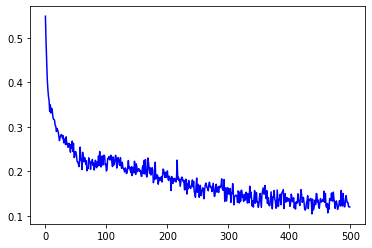

In [88]:
# PLOTANDO O GRÁFICO DA FUNÇÃO DE CUSTO
print("GRÁFICO DA FUNÇÃO DE CUSTO")
plt.plot(losses, 'b')
plt.show()

### Fazer a predição do dataset de Teste e validar a acurácia 

In [89]:
# fazer predição de teste
with torch.no_grad():
    predicoes = model(X_test)
    if torch.cuda.is_available():
        # Só trocando o local
        predicoes = predicoes.cpu()
    y_hat = np.argmax(predicoes, axis=1).flatten()

In [90]:
corrects = [1 if corr == pred else 0 for corr, pred in zip(y_test, y_hat)]

In [91]:
acurracy = np.sum(corrects) / len(y_test)
print(f'Acurácia: {acurracy}')

Acurácia: 0.9123487482664252


O método `eval` coloca o modelo em um modo de avaliação, ajustando o comportamento de certas camadas, por isso ele foi usado aqui para ver o como ele influencia nos resultados da base de validação.

In [83]:
model.eval()

with torch.no_grad():
    predicoes = model(X_validation)
    if torch.cuda.is_available():
        # Só trocando o local
        predicoes = predicoes.cpu()
    y_hat = np.argmax(predicoes, axis=1).flatten()

In [84]:
corrects = [1 if corr == pred else 0 for corr, pred in zip(y_validation, y_hat)]

In [85]:
acurracy = np.sum(corrects) / len(y_test)
print(f'Acurácia da validação: {acurracy}')

Acurácia da validação: 0.9143934410356739


In [99]:
# Exibir a predição por classe, só pra garantir que não está prevendo tudo de uma classe só
unique, counts = np.unique(y_hat.numpy(), return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

[[    0 16698]
 [    1 14560]
 [    2 72979]
 [    3  3272]
 [    4   155]
 [    5  5434]
 [    6  1059]
 [    7   820]
 [    8   112]
 [    9  1560]
 [   10   393]
 [   11    10]]


### Dados de Acurácia

Aqui é apresentado uma tabela com os dados de acurácia do dataset de treino (da fase de testes 80%-20% do dataser original), junto com os dados sobre o modelo, dataset usado e outras tecnicas empregadas.

<table>
  <tr>
    <th>Modelo</th>
    <th>Dados usados</th>
    <th>Tipo de treinamento</th>
    <th>Outros parâmetros</th>
    <th>Acurácia no treino</th> 
  </tr>
    
  <tr>
    <td rowspan="17">ModelSimples</td>
    <td>dataset completo</td>
    <td>Normal</td>
    <td>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6158015916071131</td>
  </tr>
  <tr>
    <td>dataset compostos colunas com 'Normalized' e 'Delta' no nome</td>
    <td>Normal</td>
    <td>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6323028752301337</td>
  </tr>
  <tr>
    <td>dataset compostos colunas com 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.627527199566003</td>
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6158015916071131</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Aplicado: MinMaxScaler <br/>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6505085368406215</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' no nome (colunas 'encoded' foram adicionadas)</td>
    <td>Normal</td>
    <td>Aplicado: MinMaxScaler <br/>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6158015916071131</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.7362742040896528</td>
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam com penalização L2 (regularização) <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.7510839245972927</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' no nome (colunas 'encoded' foram adicionadas)</td>
    <td>Normal</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.7293840745312961</td>
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: SGD <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.7459280743946041</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam com uso de pesos pra tentar balancear<br/>Épocas: 100 <br/>Learning Rate: 0.05 <br/> Neurônios nas camadas ocultas: 176</td>
    <td>0.5400229813372747</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Normal</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam com uso de pesos pra tentar balancear<br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.5560372998210189</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 128</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.7436726569074297</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 128</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: SGD <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.9067376325805308</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 128</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001</td>
    <td>0.9177925955669086</td> 
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001</td>
    <td>0.9180955310078512</td>
  </tr>
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: SGD <br/>Épocas: 500 <br/>Learning Rate: 0.001</td>
    <td>0.9047769571513393</td>
  </tr>
    
  <tr>
    <td rowspan="4">Model2Camadas</td>
    <td>dataset completo</td>
    <td>Normal</td>
    <td>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05 <br/> Neurônios nas camadas ocultas foi reduzido, não atende a fórmula apresentada</td>
    <td>0.7097346039990944</td> 
  </tr>  
  <tr>
    <td>dataset completo</td>
    <td>Normal</td>
    <td>Optimazer: Adam com penalização L2 (regularização) <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6932803082403899</td> 
  </tr>  
  <tr>
    <td>dataset completo</td>
    <td>Normal</td>
    <td>Optimazer: SGD com penalização L2 (regularização) <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.7348090370477952</td> 
  </tr> 
  <tr>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 128</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: SGD <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.9079037859403767</td> 
  </tr>
    
  <tr>
    <td>Model3Camadas</td>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 128</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: SGD <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.9041832014113446</td>
  </tr> 
    
  <tr>
    <td rowspan="3">ModelDropout</td>
    <td>dataset completo (?)</td>
    <td>Normal</td>
    <td>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6158015916071131</td> 
  </tr>   
  <tr>
    <td>dataset completo (?)</td>
    <td>Normal</td>
    <td>Optimazer: SGD com penalização L2 (regularização) <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.6980047244161758</td>
  </tr>   
  <tr>
    <td>dataset completo (?)</td>
    <td>Minibatch de tamanho 128</td>
    <td>Optimazer: SGD com penalização L2 (regularização) <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.8864089738277596</td> 
  </tr>  
    
  <tr>
    <td>ModelSimplesDropout</td>
    <td>dataset completo (?)</td>
    <td>Normal</td>
    <td>Optimazer: Adam <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.9070152881423988</td> 
  </tr> 
    
  <tr>
    <td>Model4Camadas</td>
    <td>dataset completo (?)</td>
    <td>Minibatch de tamanho 128</td>
    <td>Optimazer: SGD com penalização L2 (regularização) <br/>Épocas: 100 <br/>Learning Rate: 0.05</td>
    <td>0.8940850822074045</td> 
  </tr>
</table>

**Notas da tabela:**
- Colunas com \'?\' se referem uma informação que talvez esteja correta, mas como os dados mais precisos só foram anotados depois do começo dos testes pode ser que esta dado não esteja totalmente correto;
- O ModelSimples tem mais dados pois ele foi o primeiro a ser montado e sempre era o primeiro a ser testado com alguma mudança de configuração. Nem todos os modelos foram testado com todas as configurações usadas e se algum mostrase um desempenho pior com alguma configuração as vezes o resultado nem era anotado;
- Foi tentado anotar de cada teste, sempre presando manter informações sobre os que tiveram uma acurácia maior, sendo assim pode ser que alguma informações estejam com algum dado não totalmente correto, pela falta de anotação. Se desejar verificar, é só fazer o teste com as informações apresentadas.
- Os números de neurônios geralmente seguiam a fórmula: 
$$ número\ de\ neurônios = \frac{numero\ de\ exemplos\ de\ treino}{Fator * (Neurônios\ de\ entrada + Neurônios\ de\ saída)} $$

Contudo as vezes se o número fosse muito grande (> 700) ele era dividido por 3 até ficar entre 500~700. Se nos dados da tabela não estiver dito o número, é para ser o número obtido pela fórmula. Caso durante os testes exista alguma diferença pode ser em decorrencia do número não ter sido anotado e ele ser diferente do resultado da fórmula. Note que o valor de $Fator$ pode influenciar no número de neurônios sugerido;
- Alguns parâmetros usados nos _optimazers_ podem não ter sido anotados e estarem diferentes da última versão do notebook, visto que eles podemter sido incluidos ou removidos, isso também pode influenciar em algumas diferenças caso o teste seja rodado novamente.

A tabela a baixo foi obtida usando a separação de 60%-20%-20% do dataset original, usando `StandardScaler` e `Adam`. Basicamente foram o que se considerou os melhores parâmetros encontrados durante os testes com o dataset dividido em 80%-20%. Também foi aplicado o método `eval` depois do teste para realizar a validação.

<table>
  <tr>
    <th>Modelo</th>
    <th>Dados usados</th>
    <th>Tipo de treinamento</th>
    <th>Outros parâmetros</th>
    <th>Acurácia no treino</th> 
    <th>Acurácia na validação</th>
  </tr>
    
  <tr>
    <td>ModelSimples</td>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001 <br/>Neurônios nas camadas ocultas: 530</td>
    <td>0.9094753568957121</td>    
    <td>0.9087833508470666</td>
  </tr>
    
  <tr>
    <td>Model2Camadas</td>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001 <br/>Neurônios nas camadas ocultas: 530 e suas variações</td>
    <td>0.9120639721147192</td>    
    <td>0.9116425034101944</td>
  </tr>
    
  <tr>
    <td>Model3Camadas</td>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001 <br/>Neurônios nas camadas ocultas: 530 e suas variações</td>
    <td>0.9100591480067093</td>    
    <td>0.909515225556951</td>
  </tr> 
    
  <tr>
    <td>ModelDropout</td>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001 <br/>Neurônios nas camadas ocultas: 530 e suas variações</td>
    <td>0.9017977918457196</td> 
    <td>0.9140517096536268</td>
  </tr>  
    
  <tr>
    <td>ModelSimplesDropout</td>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001 <br/>Neurônios nas camadas ocultas: 530 e suas variações</td>
    <td>0.9073708611346052</td> 
    <td>0.9143934410356739</td>
  </tr> 
    
  <tr>
    <td>Model4Camadas</td>
    <td>dataset compostos colunas sem 'Normalized', 'Delta' e 'encoded' no nome</td>
    <td>Minibatch de tamanho 256</td>
    <td>Aplicado: StandardScaler <br/>Optimazer: Adam <br/>Épocas: 500 <br/>Learning Rate: 0.001 <br/>Neurônios nas camadas ocultas: 530 e suas variações</td>
    <td>0.9123487482664252</td> 
    <td>0.9143934410356739</td>
  </tr>
</table>

## Treinamento do Modelo Escolhido

Com base nos testes com a base divida em 80%-20% o modelo escolhido foi: o ModelSimples com 530 neurônios, com Adam, taxa de aprendizagem em 0.001, minibatch de 128 e treinado por 500 épocas. Já com base nos testes usando a base dividia em 60%-20%-20% e usando o método `eval` o modelo selecionado foi o Model2Camadas com 530 neurônios, com Adam, taxa de aprendizagem em 0.001, minibatch de 256 e treinado por 500 épocas.

Ambos os modelos serão treinados nesses moldes para classificar o arquivo _hidden.csv_. Os seus estados serão salvos depois do treinamento.

Com relação ao _dataset_, sersão usadas só as colunas sem _Nomalized_, _Delta_ ou _encoded_ no nome. Todas as colunas usadas serão normalizadas usando um _StandardScaler_, que teve um desempenho melhor nos testes. O treino será feito com o _dataset_ completo e o scaler treinado para o dataset será usado para normalizar os dados do _hidden.csv_.

Primeiro devemos fazer a separação e normalização, usando os valores de _y_ e _df_lithology_features_

In [29]:
y_model = y.copy()
df_feature_model = get_features(df_lithology_features, 'normal')

scaler = get_scaler('standard')
X_model = scaler.fit_transform(df_feature_model)

In [30]:
X_model = torch.FloatTensor(X_model).to(device)
y_model = torch.LongTensor(y_model.values).to(device)

In [31]:
prediction_model = Model2Camadas(X_train.shape[1]).to(device)
optimizer = get_optimazer('adam', prediction_model, lr=0.001)
loss_fn = nn.CrossEntropyLoss().to(device)
prediction_model

Model2Camadas(
  (layer1): Linear(in_features=21, out_features=530, bias=True)
  (layer2): Linear(in_features=530, out_features=265, bias=True)
  (layer3): Linear(in_features=265, out_features=265, bias=True)
  (out): Linear(in_features=265, out_features=12, bias=True)
)

In [32]:
print(len(y_model))

1170511


In [33]:
losses = train_model('mini_batch', X_model, y_model, prediction_model, loss_fn, optimizer, n_epochs=500, mini_batch_size=256)

epoch:  0  loss: 1.03775609
epoch:  1  loss: 1.55339539
epoch:  2  loss: 1.10266387
epoch:  3  loss: 0.77106619
epoch:  4  loss: 0.67388922
epoch:  5  loss: 0.67242163
epoch:  6  loss: 0.68082166
epoch:  7  loss: 0.62170231
epoch:  8  loss: 0.63677168
epoch:  9  loss: 0.78857780
epoch: 10  loss: 0.65310657
epoch: 11  loss: 0.59303319
epoch: 12  loss: 0.61916339
epoch: 13  loss: 0.59859127
epoch: 14  loss: 0.51603335
epoch: 15  loss: 0.55125999
epoch: 16  loss: 0.59293246
epoch: 17  loss: 0.61521959
epoch: 18  loss: 0.67023200
epoch: 19  loss: 0.58596355
epoch: 20  loss: 0.58008355
epoch: 21  loss: 0.58002603
epoch: 22  loss: 0.61438763
epoch: 23  loss: 0.63564247
epoch: 24  loss: 0.48565236
epoch: 25  loss: 0.56102258
epoch: 26  loss: 0.48241800
epoch: 27  loss: 0.54762357
epoch: 28  loss: 0.44807541
epoch: 29  loss: 0.56074017
epoch: 30  loss: 0.46908256
epoch: 31  loss: 0.57899922
epoch: 32  loss: 0.57648379
epoch: 33  loss: 0.55393332
epoch: 34  loss: 0.55786389
epoch: 35  loss: 0.6

epoch: 286  loss: 0.20998962
epoch: 287  loss: 0.20060655
epoch: 288  loss: 0.25250274
epoch: 289  loss: 0.24091218
epoch: 290  loss: 0.23395492
epoch: 291  loss: 0.24467736
epoch: 292  loss: 0.20484127
epoch: 293  loss: 0.21082053
epoch: 294  loss: 0.20283040
epoch: 295  loss: 0.19801925
epoch: 296  loss: 0.22639653
epoch: 297  loss: 0.20745881
epoch: 298  loss: 0.19585784
epoch: 299  loss: 0.18161309
epoch: 300  loss: 0.21139765
epoch: 301  loss: 0.21339701
epoch: 302  loss: 0.19864893
epoch: 303  loss: 0.21996957
epoch: 304  loss: 0.24177115
epoch: 305  loss: 0.20108913
epoch: 306  loss: 0.25503418
epoch: 307  loss: 0.21579269
epoch: 308  loss: 0.20178977
epoch: 309  loss: 0.19507888
epoch: 310  loss: 0.26479194
epoch: 311  loss: 0.20955019
epoch: 312  loss: 0.22442681
epoch: 313  loss: 0.20294404
epoch: 314  loss: 0.22211619
epoch: 315  loss: 0.17217429
epoch: 316  loss: 0.23617341
epoch: 317  loss: 0.28000227
epoch: 318  loss: 0.23684715
epoch: 319  loss: 0.21760313
epoch: 320  lo

In [34]:
# Salvar o modelo pra poder usar ele depois

torch.save(prediction_model.state_dict(), 'prediction_Model2Camadas.pth')

In [39]:
# Carregar o modelo salvo
# Usar isso para carregar um dos dois modelos já salvos, o padrão de nome é prediction_<nome do modelo>.pth
prediction_model.load_state_dict(torch.load('prediction_ModelSimples.pth', map_location=device))
prediction_model.eval()

ModelSimples(
  (layer1): Linear(in_features=21, out_features=530, bias=True)
  (layer2): Linear(in_features=530, out_features=530, bias=True)
  (out): Linear(in_features=530, out_features=12, bias=True)
)

### Preparação dos dados

Carregar e preparar os dados do arquivos _hidden.csv_.

In [35]:
df_hidden = pd.read_csv('hidden.csv', sep=';')
df_hidden.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,Carbon_Index,Normalized_RHOB,Normalized_GR,Delta_DTC,Delta_RHOB,Delta_GR,Delta_DEPTH_MD,Delta_Carbon_Index,GROUP_encoded,FORMATION_encoded
0,1518.280,433906.75,6460000.5,-1493.241821,15.506232,-999.0,-999.000000,0.878615,-999.0,103.451515,...,-999.0,-999.0,0.229715,-0.000000,-999.0,-0.000000,0.000,-999.0,5,51
1,1518.432,433906.75,6460000.5,-1493.393799,18.524611,-999.0,-999.000000,0.874237,-999.0,94.124893,...,-999.0,-999.0,0.206369,1.616959,-999.0,9.326622,0.152,-999.0,5,51
2,1518.584,433906.75,6460000.5,-1493.545776,18.855669,-999.0,-999.000000,0.869858,-999.0,93.586487,...,-999.0,-999.0,0.205021,0.131363,-999.0,0.538406,0.152,-999.0,5,51
3,1518.736,433906.75,6460000.5,-1493.697754,19.163353,-999.0,-999.000000,0.865479,-999.0,91.113373,...,-999.0,-999.0,0.198831,1.637512,-999.0,2.473114,0.152,-999.0,5,51
4,1518.888,433906.75,6460000.5,-1493.849609,18.489744,-999.0,0.849849,0.863804,-999.0,100.228333,...,-999.0,-999.0,0.221647,0.819153,-999.0,-9.114960,0.152,-999.0,5,51


In [36]:
df_hidden_model = get_features(df_hidden, 'normal')
df_hidden_model.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,PEF,DTC,SP,BS,ROP,DCAL,DRHO,MUDWEIGHT,RMIC,Carbon_Index
0,1518.280,433906.75,6460000.5,-1493.241821,15.506232,-999.0,-999.000000,0.878615,-999.0,103.451515,...,-999.0,147.043427,-999.0,17.5,146.526276,-1.993768,0.109706,-999.0,-999.0,-999.0
1,1518.432,433906.75,6460000.5,-1493.393799,18.524611,-999.0,-999.000000,0.874237,-999.0,94.124893,...,-999.0,145.426468,-999.0,17.5,147.605148,1.024611,-0.006418,-999.0,-999.0,-999.0
2,1518.584,433906.75,6460000.5,-1493.545776,18.855669,-999.0,-999.000000,0.869858,-999.0,93.586487,...,-999.0,145.295105,-999.0,17.5,140.783127,1.355669,0.022769,-999.0,-999.0,-999.0
3,1518.736,433906.75,6460000.5,-1493.697754,19.163353,-999.0,-999.000000,0.865479,-999.0,91.113373,...,-999.0,143.657593,-999.0,17.5,125.159531,1.663353,0.024972,-999.0,-999.0,-999.0
4,1518.888,433906.75,6460000.5,-1493.849609,18.489744,-999.0,0.849849,0.863804,-999.0,100.228333,...,-999.0,142.838440,-999.0,17.5,107.576691,0.989744,0.024527,-999.0,-999.0,-999.0


In [37]:
# Utilizar o scaler já usado nos treinos
X_hidden = scaler.transform(df_hidden_model)

Colocar os dados no padrão do PyTorch.

In [38]:
X_hidden = torch.FloatTensor(X_hidden).to(device)

### Realização da Predição

In [39]:
prediction_model.eval()
with torch.no_grad():
    predicoes = prediction_model(X_hidden)
    if torch.cuda.is_available():
        # Só trocando o local
        predicoes = predicoes.cpu()
    y_hat = np.argmax(predicoes, axis=1).flatten()

Criação do _dataframe_ com os resultados.

In [40]:
df_hidden_lithology = pd.DataFrame(y_hat.numpy(), columns=['lithology'])
df_hidden_lithology.head()

,lithology
0,2
1,2
2,2
3,2
4,2


Mapeamento da coluna de saída para o padrão do arquivo _lithology.csv_.

In [41]:
df_hidden_lithology['lithology'] = df_hidden_lithology['lithology'].apply(lambda x: idx_to_class_map[x])
df_hidden_lithology.head()

,lithology
0,65000
1,65000
2,65000
3,65000
4,65000


<AxesSubplot:>

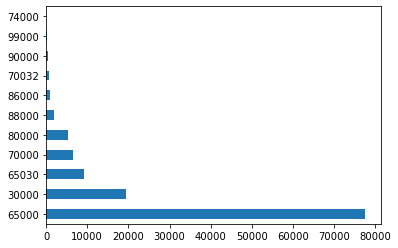

In [42]:
df_hidden_lithology['lithology'].value_counts().plot(kind = 'barh')

Salvar o arquivo com o padrão de nome de acordo com o modelo usado para a classificação.

In [43]:
df_hidden_lithology.to_csv('df_hidden_lithology_Model2Camadas.csv', index=False)

Referencias de consultas e métodos:

https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

https://www.kaggle.com/cboychinedu/starter-hole-deviation-prediction-eda

https://androidkt.com/how-to-use-class-weight-in-crossentropyloss-for-an-imbalanced-dataset/

https://medium.com/@ozgur.ersoz3/iris-flowers-classification-with-pytorch-cd80c8aeeb2c

https://janakiev.com/blog/pytorch-iris/

https://pytorch.org/docs/stable/index.html